In [1]:
from pathlib import Path

from PIL import Image
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from unet import AttUNet, UNet, UNetWithPretrainedEncoder
from dataloader import ImageDataset, TransformWrapper

data_pth = Path(
    '/Users/tsakalis/Downloads/ECImageAnalysisMouse/New Binary Masks')
blastocyst_pth = Path('/Users/tsakalis/ntua/cellforge/data/')

blastocyst_images_pth = blastocyst_pth / 'blastocyst_images'
blastocyst_msk_pth = blastocyst_pth / 'blastocyst_masks'

smooth = 1e-15

device = 'mps'


def dice_coef(y_pred, y_true):

    intersection = torch.sum(y_true.flatten() * y_pred.flatten())
    return (2. * intersection + smooth) / (
        torch.sum(y_true).flatten() + torch.sum(y_pred).flatten() + smooth)


def dice_loss(y_pred, y_true):

    return 1.0 - dice_coef(y_true, y_pred)


In [2]:
image_file_paths = []
mask_file_paths = []

for mouse in data_pth.glob('*'):
    if len(list(mouse.glob('*'))) == 2:

        msk1, msk2 = list(mouse.glob('*'))

        if 'masked' in msk2.name.lower():
            image_file_paths.append(msk1)
            mask_file_paths.append(msk2)
        else:
            mask_file_paths.append(msk1)
            image_file_paths.append(msk2)

In [3]:
# image_file_paths = sorted(list((data_pth / "images").glob('*.png')),
#                           key=lambda x: x.stem)
# mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
#                          key=lambda x: x.stem)


In [4]:
import numpy as np
from PIL import Image
from scipy.ndimage import center_of_mass


def crop_around_center(image: Image.Image, mask: Image.Image,
                       crop_size: int) -> Image.Image:
    """
    Finds the center of mass of the non-zero pixels in the image
    and crops the image around that point.

    Args:
        image (PIL.Image.Image): Input image (grayscale or binary recommended).
        crop_size (int): Size of the square crop (e.g., 128 for 128x128 crop).

    Returns:
        PIL.Image.Image: Cropped image around the center of mass.
    """
    # Convert image to grayscale and NumPy array
    image_array = np.array(image.convert("L"))

    # Find the center of mass of non-zero pixels
    com = center_of_mass(image_array)

    # Round to integers for pixel indexing
    center_y, center_x = map(int, com)

    # Calculate crop box
    half_crop = crop_size // 2
    left = max(center_x - half_crop, 0)
    upper = max(center_y - half_crop, 0)
    right = min(center_x + half_crop, image.width)
    lower = min(center_y + half_crop, image.height)

    # Crop the image
    cropped_image = image.crop((left, upper, right, lower))

    cropped_mask = mask.crop((left, upper, right, lower))
    return cropped_image, cropped_mask


# Example usage


In [5]:
# image_file_paths = sorted(list((data_pth / "images").glob('*.jpg')),
#                           key=lambda x: x.stem)
# mask_file_paths = sorted(list((data_pth / "masks").glob('*.png')),
#                          key=lambda x: x.stem)

# print("... Loading images ...")
images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]
masks = [Image.open(msk_pth) for msk_pth in tqdm(mask_file_paths)]


def remove_alpha(img):
    if img.mode == 'RGBA':  # If image has an alpha channel
        background = Image.new('RGB', img.size,
                               (255, 255, 255))  # Create white background
        background.paste(img, mask=img.split()[3])  # Use alpha channel as mask
        return background
    return img  # Return unchanged if no alpha channel


# Process images and masks
images = [remove_alpha(img) for img in tqdm(images)]
masks = [remove_alpha(msk) for msk in tqdm(masks)]

cropped_images = []
cropped_masks = []
for image, mask in zip(images, masks):

    cropped, cropped_mask = crop_around_center(image, mask, crop_size=200 * 3)

    cropped_images.append(cropped)
    cropped_masks.append(cropped_mask)

train_dataset = ImageDataset(images=cropped_images[:130],
                             masks=cropped_masks[:130],
                             transform=True)
val_dataset = ImageDataset(images=cropped_images[130:800],
                           masks=cropped_masks[130:800])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=16)


  0%|          | 0/169 [00:00<?, ?it/s]

100%|██████████| 169/169 [00:02<00:00, 71.84it/s]


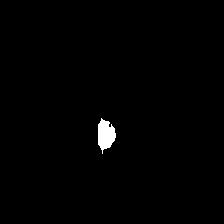

In [6]:
temp_msk = cropped_masks[160].resize((224, 224), Image.Resampling.LANCZOS)
temp_img = cropped_images[160].resize((224, 224), Image.Resampling.LANCZOS)
temp_msk = temp_msk.convert('L')
binary_threshold = 100  # Adjust this threshold as needed
mask = temp_msk.point(lambda p: 255 if p > binary_threshold else 0)
mask


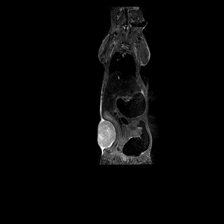

In [7]:
temp_img

In [8]:
import random
from torchvision import transforms as T
import torchvision.transforms.functional as F

In [9]:
angle = random.uniform(-90, 90)
image = F.rotate(image, angle)
mask = T.ToTensor()(F.rotate(mask, angle))

In [12]:
for im, gt in train_dataloader:
    break

In [16]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name=
    "resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=
    "imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=
    3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
)
model.to(device)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 30

/Users/tsakalis/Library/Caches/pypoetry/virtualenvs/cellforge-Tgd_YqAD-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import torch


def validate(model, val_dataloader):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for img_batch, gt_msk_batch in val_dataloader:

            img_batch = img_batch.to(device)
            gt_msk_batch = gt_msk_batch.to(device)

            pred_mask = model(img_batch)

            loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch)

            val_loss += loss.item()

    mean_val_loss = val_loss / len(val_dataloader)
    return mean_val_loss


In [18]:
for epoch in range(n_epochs):
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader))

    train_loss = 0
    for img_batch, gt_msk_batch in progress_bar:

        optimizer.zero_grad()
        pred_mask = model(img_batch.to(device))

        loss = dice_loss(torch.sigmoid(pred_mask), gt_msk_batch.to(device))
        loss.backward()
        optimizer.step()

        progress_bar.set_description(str(loss.item()))

        train_loss += loss.item()

    val_loss = validate(model, val_dataloader)

    print(
        f'Epoch {epoch+1} | TrainLoss: {train_loss/len(train_dataloader)} ValLoss: {val_loss}'
    )


0.9906126856803894: 100%|██████████| 17/17 [00:08<00:00,  2.11it/s]


Epoch 1 | TrainLoss: 0.9788966213955599 ValLoss: 0.9786242643992106


0.5941877365112305: 100%|██████████| 17/17 [00:06<00:00,  2.64it/s]


Epoch 2 | TrainLoss: 0.8245033516603357 ValLoss: 0.5998937288920084


0.5842756032943726: 100%|██████████| 17/17 [00:06<00:00,  2.63it/s] 


Epoch 3 | TrainLoss: 0.41332031698787913 ValLoss: 0.207138458887736


0.2736451029777527: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s] 


Epoch 4 | TrainLoss: 0.2857980622964747 ValLoss: 0.19943422079086304


0.37495583295822144: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch 5 | TrainLoss: 0.23681585227741914 ValLoss: 0.14821545282999674


0.18898075819015503: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch 6 | TrainLoss: 0.18441885359147014 ValLoss: 0.1362946629524231


0.23061484098434448: 100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch 7 | TrainLoss: 0.17562862704781926 ValLoss: 0.2554386059443156


0.2618676424026489: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s] 


Epoch 8 | TrainLoss: 0.19467204458573284 ValLoss: 0.13119993607203165


0.32267987728118896: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch 9 | TrainLoss: 0.1564858590855318 ValLoss: 0.11654847860336304


0.10018253326416016: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch 10 | TrainLoss: 0.14494421201593735 ValLoss: 0.13018896182378134


0.09176892042160034: 100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch 11 | TrainLoss: 0.12975513233857996 ValLoss: 0.10442833105723064


0.16694128513336182: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch 12 | TrainLoss: 0.1374799644245821 ValLoss: 0.11745494604110718


0.1324143409729004: 100%|██████████| 17/17 [00:06<00:00,  2.67it/s] 


Epoch 13 | TrainLoss: 0.1198851606425117 ValLoss: 0.09886278708775838


0.08004021644592285: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch 14 | TrainLoss: 0.10923703277812284 ValLoss: 0.08966461817423503


0.06450408697128296: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch 15 | TrainLoss: 0.1049318979768192 ValLoss: 0.09131375948588054


0.0948488712310791: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s] 


Epoch 16 | TrainLoss: 0.09780833651037778 ValLoss: 0.08671528100967407


0.091297447681427: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]  


Epoch 17 | TrainLoss: 0.1004821588011349 ValLoss: 0.09666772683461507


0.08574599027633667: 100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch 18 | TrainLoss: 0.10244153177036959 ValLoss: 0.08401942253112793


0.05383718013763428: 100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch 19 | TrainLoss: 0.09144482542486752 ValLoss: 0.0775888164838155


0.13088446855545044: 100%|██████████| 17/17 [00:06<00:00,  2.65it/s] 


Epoch 20 | TrainLoss: 0.09426332221311681 ValLoss: 0.09388985236485799


0.09332340955734253: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch 21 | TrainLoss: 0.116147121962379 ValLoss: 0.092498779296875


0.057347774505615234: 100%|██████████| 17/17 [00:06<00:00,  2.67it/s]


Epoch 22 | TrainLoss: 0.10028444318210378 ValLoss: 0.08961878220240276


0.03636986017227173: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch 23 | TrainLoss: 0.09332882656770594 ValLoss: 0.09903995196024577


0.0800662636756897: 100%|██████████| 17/17 [00:06<00:00,  2.65it/s] 


Epoch 24 | TrainLoss: 0.0924635319148793 ValLoss: 0.07733700672785442


0.0765448808670044:  82%|████████▏ | 14/17 [00:05<00:01,  2.42it/s] 


KeyboardInterrupt: 

In [19]:
import torch


def compute_iou_and_dice(pred: torch.Tensor,
                         gt: torch.Tensor) -> tuple[float, float]:
    """
    Compute IoU and Dice metrics for binary segmentation masks using PyTorch.

    Args:
        pred (torch.Tensor): Predicted binary mask (0 or 1), shape (H, W).
        gt (torch.Tensor): Ground truth binary mask (0 or 1), shape (H, W).

    Returns:
        tuple[float, float]: IoU and Dice scores.
    """
    # Ensure binary masks (threshold at 0.5 for soft predictions)
    pred = (pred > 0.5).float()
    gt = (gt > 0.5).float()

    # Compute intersection and union
    intersection = torch.sum(pred * gt)
    union = torch.sum(pred) + torch.sum(gt) - intersection

    # Compute IoU
    iou = (intersection / union).item() if union > 0 else 0.0

    # Compute Dice coefficient
    dice = (2 * intersection / (torch.sum(pred) + torch.sum(gt))).item() if (
        torch.sum(pred) + torch.sum(gt)) > 0 else 0.0

    return iou, dice


# # Example usage
# pred_mask = torch.randint(0, 2, (256, 256),
#                           dtype=torch.float32)  # Example predicted mask
# gt_mask = torch.randint(0, 2, (256, 256),
#                         dtype=torch.float32)  # Example ground truth mask

iou_fn, dice_fn = compute_iou_and_dice(torch.sigmoid(pred_mask),
                                       gt_msk_batch.to(device))
print(f"IoU: {iou_fn:.4f}, Dice: {dice_fn:.4f}")


IoU: 0.8669, Dice: 0.9287


In [20]:
model.eval()
gt_masks_all = []
pred_masks_all = []

all_images = []
for img_batch, gt_msk_batch in val_dataloader:

    pred_mask = model(img_batch.to(device))
    all_images.append(img_batch)
    pred_masks_all.append(pred_mask.to('cpu'))
    gt_masks_all.append(gt_msk_batch.to('cpu'))


In [23]:
from torchmetrics import JaccardIndex, Dice


In [25]:
iou_fn = JaccardIndex(task='binary', threshold=0.90)
dice_fn = Dice(threshold=0.90)

iou_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all))

dice_fn(
    torch.sigmoid(torch.vstack(pred_masks_all)),
    torch.vstack(gt_masks_all).long(),
)

print(
    f"IoU: {iou_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all)):.3f}"
)

print(
    f"Dice Coeff: {dice_fn(torch.sigmoid(torch.vstack(pred_masks_all)), torch.vstack(gt_masks_all).long()):.3f}"
)

sample_pred_mask = torch.sigmoid(pred_masks_all[2][3][0].detach())

sample_gt_mask = gt_masks_all[2][3][0].detach()

IoU: 0.844
Dice Coeff: 0.916


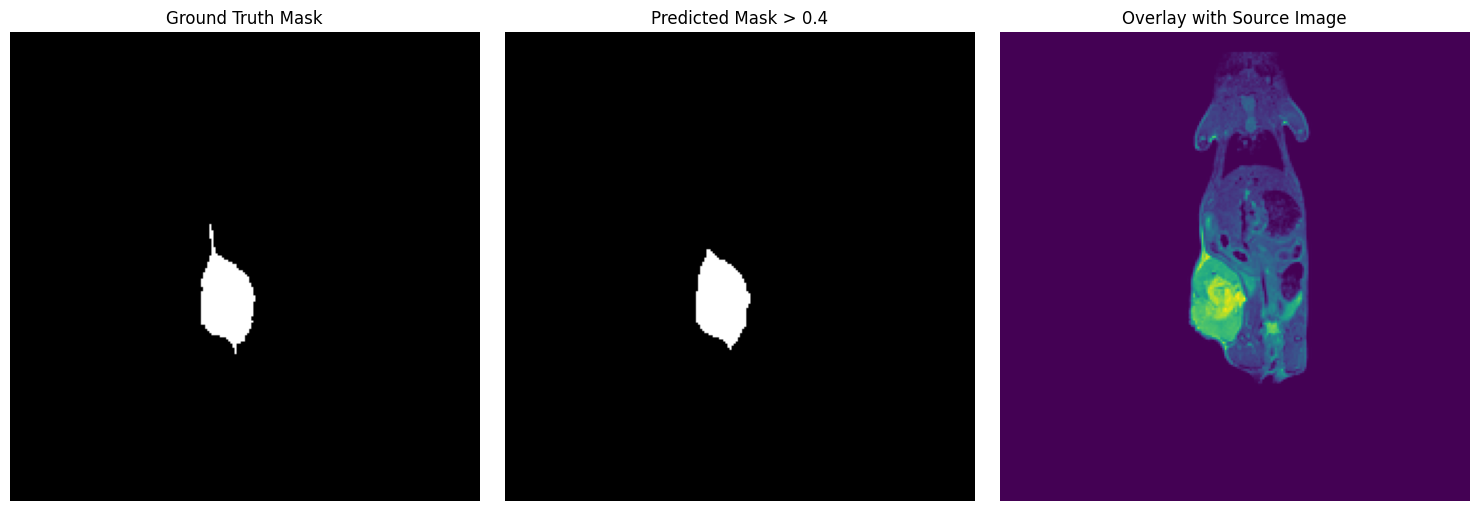

In [26]:
import matplotlib.pyplot as plt

# Assuming 'source_image', 'sample_gt_mask', and 'sample_pred_mask' are numpy arrays
# Display side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original ground truth mask
axes[0].imshow(sample_gt_mask.numpy(), cmap='gray')
axes[0].set_title("Ground Truth Mask")
axes[0].axis('off')

# Prediction mask thresholded
axes[1].imshow(sample_pred_mask > 0.4, cmap='gray')
axes[1].set_title("Predicted Mask > 0.4")
axes[1].axis('off')

# Overlay source image with ground truth and predicted masks
overlay_image = all_images[2][3][0].numpy().copy()
# Adjust overlay to include masks for better visibility
# overlay_image[sample_gt_mask > 0] = [255, 0, 0]  # Example: red for GT
# overlay_image[sample_pred_mask > 0.95] = [0, 255,
#                                           0]  # Example: green for prediction

axes[2].imshow(overlay_image)
axes[2].set_title("Overlay with Source Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()
